# **Group Project Report**
### *Classifying Cammeo and Osmancik Rice Grains*

<img align="left" src="https://turkishmart.ca/cdn/shop/products/Turkishmart_rice-sale-in-superstore_1024x1024.jpg?v=1665713014" width="300" />

*Source: https://turkishmart.ca/products/reis-osmancik-rice-1kg/*
# 1. Introduction

Rice is arguably the most important crop globally due to its economic and nutritional value. The global export value of rice is estimated at 20 billion US dollars. Rice is the primary source of food energy for about half the world’s population. The growing, cultivating and processing of rice provides employment and livelihood to millions around the world. There are more than 100,000 varieties of rice in the world and they differ in their texture, size, flavor, ways of cooking them, as well as their nutritional content. 

Depending on the variety of rice, the cultivation practices best suited for them to produce a high yield can vary. Once they are cultivated, the cost of the produce and its quality standard are influenced heavily by the variety they belong to. It is therefore important to be able to accurately and easily distinguish between the different varieties of rice.

Here we will examine two rice species cultivated in Turkey - Osmancik and Cammeo - and how we can use the data related to their morphological features like size, perimeter, surface area, etc., to classify between the two. Although both appear similar in terms of dimensions and glassy exterior, we aim to train our model to distinguish the two using other specifications. An accumulated 3810 images of rice were taken and 7 structural features were obtained for each grain of rice. In the following sections of this report, we will do an exploratory analysis to determine the relationship between predictors and the response variable, choose the predictors, prepare a model to classify the rice varieties using the K-nearest neighbour classification algorithm, choose the best k-value for the model, perform cross-validation and check accuracy. We will then summarize the results and discuss their implicatins.


# 2. Methods and Results
## Preliminary Exploratory Data Analysis
Before exploring the data, we first load several packages in order to clean and wrangle the data which will be visualized later.


In [24]:
### Run this cell to load packages and set options
library(tidyverse)
library(tidymodels)
library(janitor)
library(repr)

options(repr.matrix.max.rows = 6)
options(repr.plot.width = 8, repr.plot.height = 8)

#### I. Demonstrate that the dataset can be read from the web into R 


In [29]:
### Reading data set from the web
url <- "https://raw.githubusercontent.com/trungnguyen21/group_project_dsci/main/data/rice_data.csv"
rice_data <- read_csv(url)
cat("Table 1: Rice Dataset")
rice_data

New names:
• `` -> `...1`
Rows: 3810 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Class
dbl (8): ...1, Area, Perimeter, Major_Axis_Length, Minor_Axis_Length, Eccent...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Table 1: Rice Dataset

...1,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,15231,525.579,229.7499,85.09379,0.9288820,15617,0.5728955,b'Cammeo'
1,14656,494.311,206.0201,91.73097,0.8954050,15072,0.6154363,b'Cammeo'
2,14634,501.122,214.1068,87.76829,0.9121181,14954,0.6932588,b'Cammeo'
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
3807,12437,442.499,183.5729,86.80198,0.8811443,12645,0.6267385,b'Osmancik'
3808,9882,392.297,161.1940,78.21048,0.8744061,10097,0.6590636,b'Osmancik'
3809,11434,404.710,161.0793,90.86819,0.8256922,11591,0.8029494,b'Osmancik'


#### II. Clean and wrangle your data into a tidy format


In [30]:
### Cleaning data set: cleaning names, renaming class and changing to factor, and removing first column
rice <- rice_data |>
  clean_names() |>
  mutate(class = as_factor(class),
         class = fct_recode(class, "Cammeo" = "b'Cammeo'", "Osmancik" = "b'Osmancik'")) |>
  select(-x1)
cat("Table 2: Cleaned Rice Dataset")
rice

Table 2: Cleaned Rice Dataset

area,perimeter,major_axis_length,minor_axis_length,eccentricity,convex_area,extent,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
15231,525.579,229.7499,85.09379,0.9288820,15617,0.5728955,Cammeo
14656,494.311,206.0201,91.73097,0.8954050,15072,0.6154363,Cammeo
14634,501.122,214.1068,87.76829,0.9121181,14954,0.6932588,Cammeo
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
12437,442.499,183.5729,86.80198,0.8811443,12645,0.6267385,Osmancik
9882,392.297,161.1940,78.21048,0.8744061,10097,0.6590636,Osmancik
11434,404.710,161.0793,90.86819,0.8256922,11591,0.8029494,Osmancik


In [4]:
### Setting the seed
set.seed(2024)

### Splitting data set into training and testing data sets
rice_split <- initial_split(rice, prop = 0.75, strata = class)
rice_train <- training(rice_split)
rice_test <- testing(rice_split)

#### III. Summarize the training data

In [31]:
### Summary table: means of each predictor, missing data count, and number of observations
rice_train_summary <- rice_train |>
  mutate(na_count = rowSums(is.na(rice_train))) |>
  group_by(class) |>
  summarize(across(area:na_count, mean), obs = n())
cat("Table 3: Summary Table of Training Data")
rice_train_summary

Table 3: Summary Table of Training Data

class,area,perimeter,major_axis_length,minor_axis_length,eccentricity,convex_area,extent,na_count,obs
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Cammeo,14138.64,486.9351,205.2337,88.71779,0.9009197,14468.95,0.6511577,0,1222
Osmancik,11551.53,429.5219,176.2883,84.49649,0.8762081,11802.26,0.6684508,0,1635


#### IV. Visualize the training data

In [32]:
### Pivot long rice training set
rice_train_long <- rice_train |>
  pivot_longer(cols = area:extent, names_to = "predictor", values_to = "value")

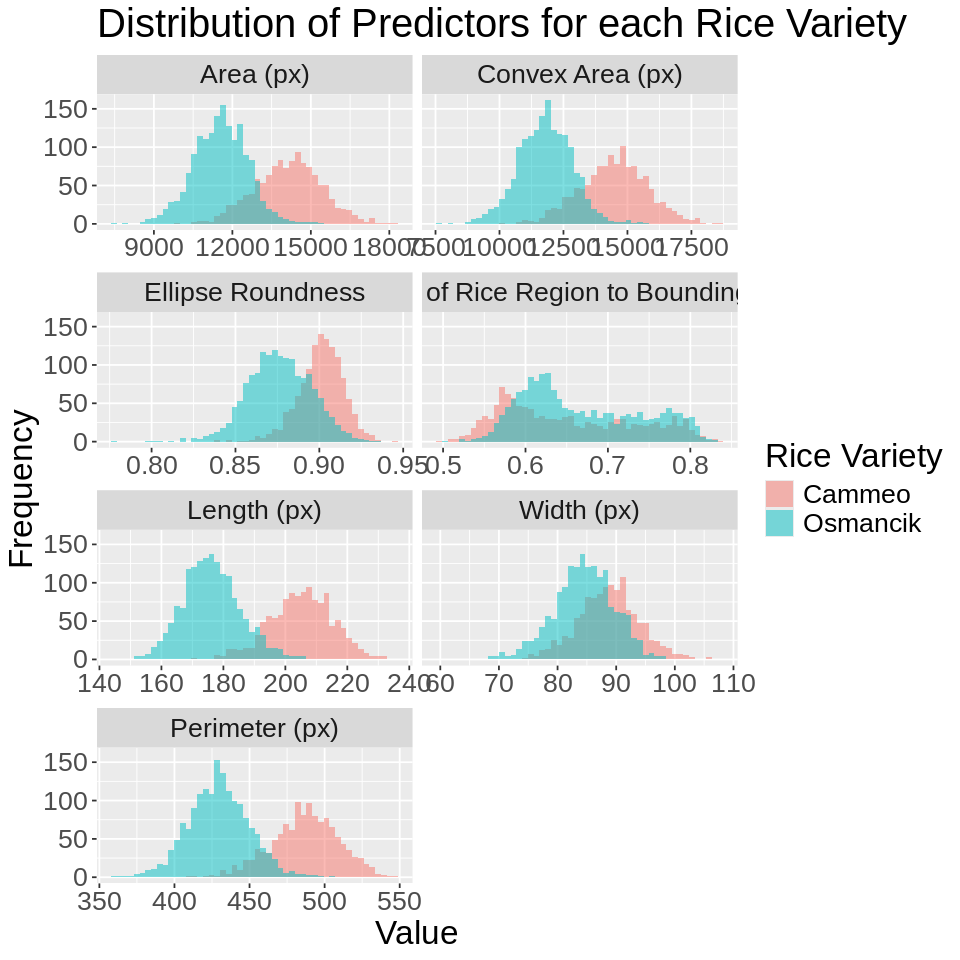

In [7]:
### Create readable labels for the histograms 
rice_labels <- c(
  area = "Area (px)",
  perimeter = "Perimeter (px)",
  major_axis_length = "Length (px)",
  minor_axis_length = "Width (px)",
  eccentricity = "Ellipse Roundness",
  convex_area = "Convex Area (px)",
  extent = "Ratio of Rice Region to Bounding Box")

### Create histograms for each predictor
rice_hist <- rice_train_long |>
  ggplot(aes(x = value, fill = class)) +
  geom_histogram(alpha = 0.5, position = "identity", bins = 50) +
  facet_wrap(~predictor, scales = "free_x", labeller = labeller(predictor = rice_labels), ncol = 2) +
  labs(title = "Distribution of Predictors for each Rice Variety",
       x = "Value", 
       y = "Frequency", 
       fill = "Rice Variety") +
  theme(text = element_text(size = 20))
rice_hist

## Data Analysis
After preliminary exploratory data analysis, it’s clear that the variables with the clearest different distributions between the 2 classes are “area”, “convex area”, “length”, and “perimeter”. The variables “ellipse roundness” and “width” have some overlap, but may still be useful. “Ratio of rice region to bounding box” will most likely be the only variable of the 7 that will not be used, as there is considerable overlap of distribution between the 2 classes.

In addition to to creating a basic K-nearest classifier using what was discussed above, we plan to use forward selection as shown in the optional Chapter 6.8 to systematically find the best variables to use to optimize our classifier.

#### I. Variable Selection Using Forward Selection

In [8]:
### Create an empty tibble to store the results
accuracies <- tibble(size = integer(),
                     model_string = character(),
                     accuracy = numeric())

### Create a model specification
knn_spec_select <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

### Create a 5-fold cross-validation object
rice_vfold_select <- vfold_cv(rice_train, v = 5, strata = class)

### Store the names of predictors
names <- colnames(rice_train |> select(-class))

### Store the total number of predictors
n_total <- length(names)

### Store selected predictors
selected <- c()

### For every size from 1 to the total number of predictors
for (i in 1:n_total) {
    ### for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        ### Create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("class", "~", paste(preds_new, collapse="+"))

        ### Create a recipe from the model string
        rice_recipe_select <- recipe(as.formula(model_string),
                                data = rice_train) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        ### Tune the K-NN classifier with these predictors and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(rice_recipe_select) |>
          add_model(knn_spec_select) |>
          tune_grid(resamples = rice_vfold_select, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        ### Add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |>
      add_row(size = i,
              model_string = models[[jstar]],
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}

In [9]:
### Display the models in order of descending accuracy
print(arrange(accuracies, -accuracy))

# A tibble: 7 × 3
   size model_string                                                    accuracy
  <int> <chr>                                                              <dbl>
1     3 class ~ major_axis_length+convex_area+area                         0.928
2     4 class ~ major_axis_length+convex_area+area+minor_axis_length       0.928
3     2 class ~ major_axis_length+convex_area                              0.928
4     5 class ~ major_axis_length+convex_area+area+minor_axis_length+e…    0.926
5     1 class ~ major_axis_length                                          0.925
6     7 class ~ major_axis_length+convex_area+area+minor_axis_length+e…    0.925
7     6 class ~ major_axis_length+convex_area+area+minor_axis_length+e…    0.925


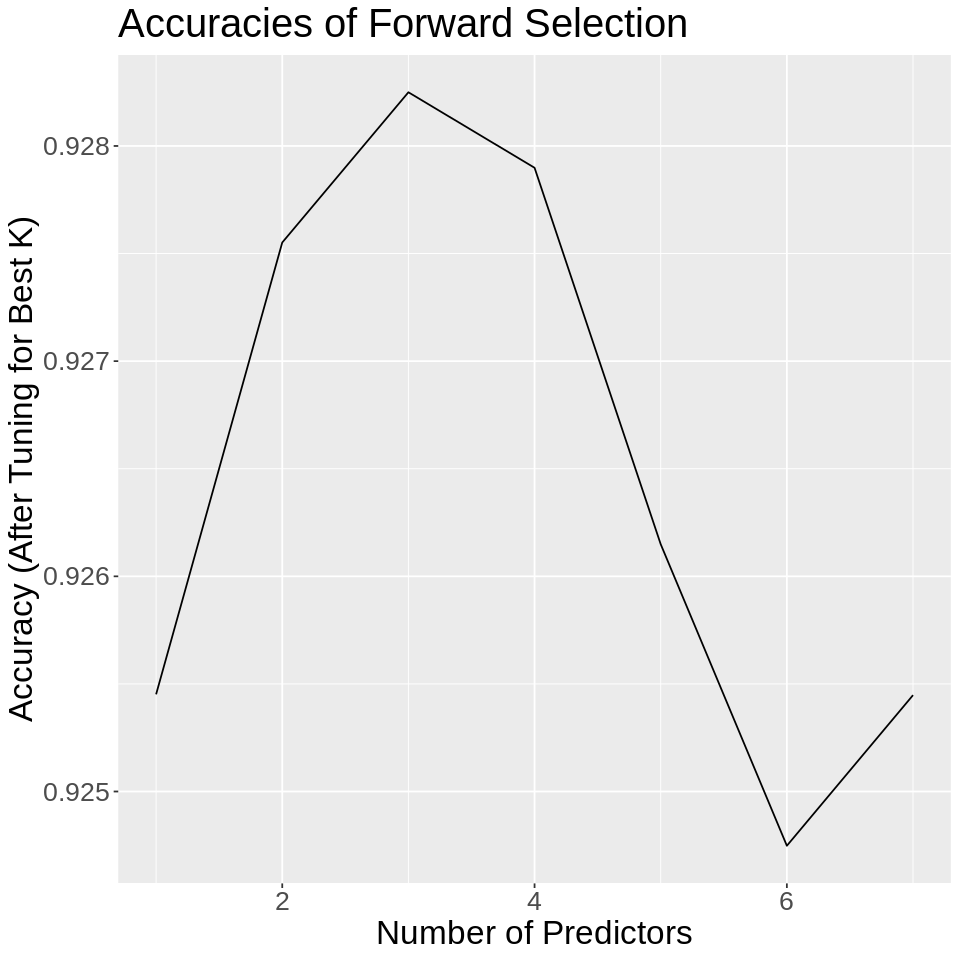

In [10]:
### Create accuracy plot of number of predictors
accuracies_plot <- accuracies |>
  ggplot(aes(x=size, y= accuracy))+
  geom_line()+
  labs(title = "Accuracies of Forward Selection",
       x = "Number of Predictors", 
       y = "Accuracy (After Tuning for Best K)") +
  theme(text = element_text(size = 20))
accuracies_plot

#### II. K-nearest Neighbour Classification Test

In [11]:
set.seed(2024)

rice_recipe <- recipe(class ~ area + perimeter + major_axis_length + eccentricity + convex_area, rice_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
  set_engine("kknn") |>
  set_mode("classification")

rice_fit <- workflow() |>
  add_recipe(rice_recipe) |>
  add_model(knn_spec) |>
  fit(rice_train)

rice_predictions <- rice_fit |>
  predict(rice_test) |>
  bind_cols(rice_test)

rice_metrics <- rice_predictions |>
  metrics(truth = class, estimate = .pred_class) |>
  filter(.metric == "accuracy")
rice_metrics

rice_conf_mat <- rice_predictions |>
  conf_mat(truth = class, estimate = .pred_class)
rice_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9213012


          Truth
Prediction Cammeo Osmancik
  Cammeo      372       39
  Osmancik     36      506

#### III. Tuning the Classifier

The process started with the crucial step of setting a seed value of 2024 to ensure the reproducibility of our experiments. Subsequently, a series of K values ranging from 1 to 20, with increments of 1 was established to fine-tune our K-nearest neighbor model. Notably, we configured the K-NN algorithm with a rectangular weight function, assigning the ‘neighbors’ parameter to ‘tune()’ instead of a fixed value. Moving forward, our dataset underwent careful preparation using a recipe designed to standardize and centralize key features, such as the major axis length, area, and convex area of rice grains. Following this, we subjected the data to the 5-fold cross-validation, stratified by rice grain class, to validate our model's performance. Our workflow incorporated both the model and recipe, facilitating a comprehensive evaluation. Importantly, rather than employing traditional fitting methods like ‘fit’ or ‘fit_resamples’, we opted for the ‘tune_grid’ function to iteratively fit the model for each value within the specified range derived from the original ‘neighbors’ data frame. Finally, we plotted the number of neighbors against the mean accuracy to identify the optimal K value—7—which yielded a mean accuracy of 92.5%, the highest out of 20 observations. 

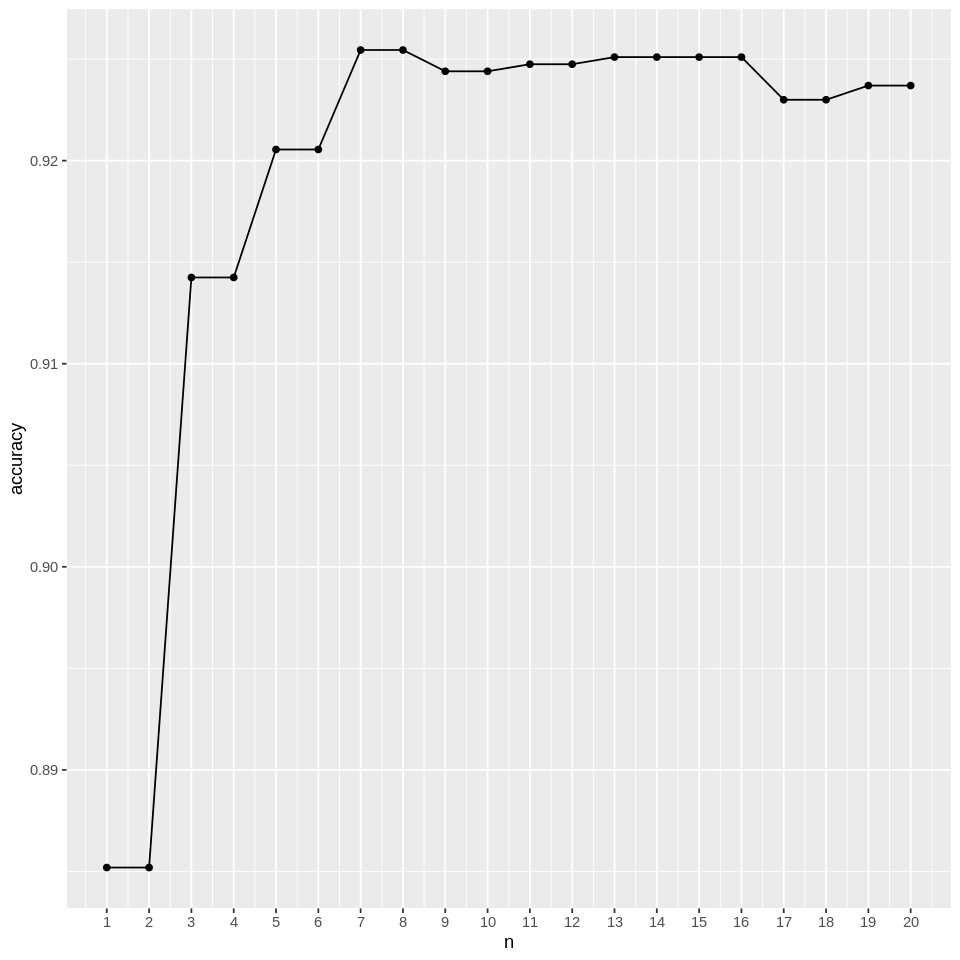

In [12]:
set.seed(2024)

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

rice_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

rice_recipe <- recipe(class ~ major_axis_length+area+convex_area, data = rice_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

rice_vfold <- vfold_cv(rice_train, v = 5, strata = class)

rice_workflow <- workflow() |>
    add_model(rice_spec) |>
    add_recipe(rice_recipe) |>
    tune_grid(resamples = rice_vfold, grid = k_vals) 

result <- rice_workflow |>
    collect_metrics() |>
    filter(.metric == "accuracy")

plot <- ggplot(result, aes(x = neighbors, y = mean)) +
               geom_line() +
               geom_point() +
               scale_x_continuous(breaks = seq(0, 20, by = 1)) +  # adjusting the x-axis
               labs(x = "n", y = "accuracy")

plot

# 3. Discussion
We expect that morphological features of rice such as its length, area, and perimeter can be used to successfully and accurately identify the species of rice. The ability to predict rice species by measuring simple physical characteristics is important in the context of agriculture and economics. The predictive analysis can be used as a quality control measure while processing and setting prices for the different varieties of rice. As a future direction, other predictors such as the nutritional content of the different species can be looked into. How this model can be expanded to species of rice other than Cammeo and Osmancik can also be explored.

We expect that morphological features of rice such as its length, area, and perimeter can be used to successfully and accurately identify the species of rice. The ability to predict rice species by measuring simple physical characteristics is important in the context of agriculture and economics. The predictive analysis can be used as a quality control measure while processing and setting prices for the different varieties of rice. As a future direction, other predictors such as the nutritional content of the different species can be looked into. How this model can be expanded to species of rice other than Cammeo and Osmancik can also be explored.  

It was found that using the K-NN classification analysis performed above, the variety of rice can be classified with 92.5 % accuracy when k=7 using major axis length, area, and convex as predictors. This is in agreement with what was predicted by the exploratory analysis as we saw a difference in the distribution of the two categories of rice when a histogram was plotted over the various physical characteristics such as length, width, area, roundness, etc. It was seen that for length and area, the peaks of the distributions of the two varieties of rice were the most far apart. Therefore, it was expected that length and area would most significantly impact the category that the rice may belong to. 

This model can be incredibly useful for application in agriculture and food processing. The ability to measure simple physical characteristics of a rice grain and use it to identify its type can act as a very efficient way of quality control. The different varieties of rice are priced differently due to the differential demand for the different morphological features of rice desired by customers. The cost of production of different rice varieties also differs greatly due to differences in the ideal growth conditions for a specific variety of a crop. The identification of rice variety by accurate quantification methods therefore has important economic implications. 

As a future direction for this project, other predictors such as the nutritional content of the different varieties of rice can be looked into and the model can be expanded to varieties of rice other than Osmancik and Cammeo. Classification can also be tried with models that use algorithms other than the K-NN classification algorithm such as random forest or support vector machine for better accuracy (Cinar & Kokulu, 2019). K-NN classification has several advantages in terms of its speed, efficiency, and flexibility. However, several challenges remain in selecting the best value of nearest neighbors and selecting the best predictors as the current algorithm does have some randomness (Zhang, 21). 


# References

Cinar, I., & Koklu, M. (2019). Classification of rice varieties using artificial intelligence methods. *International Journal of Intelligent Systems and Applications in* 

&emsp;&emsp;*Engineering, 7*(3), 188-194. https://www.ijisae.org/index.php/IJISAE/article/view/1068/599

Zhang, S. (2021). Challenges in KNN classification. *IEEE Transactions on Knowledge and Data Engineering, 34*(10), 4663-4675. 

&emsp;&emsp;https://ieeexplore.ieee.org/abstract/document/9314060